<a href="https://colab.research.google.com/github/Farjana-Yesmin/Farjana-Yesmin/blob/main/Enhanced_Iris_Classification_through_Feature_Engineering_and_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: Bagging
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
--------------------
Model: Boosting
Accuracy: 0.9667
Precision: 0.9700
Recall: 0.9667
F1-score: 0.9668
--------------------
Model: Stacking
Accuracy: 0.9667
Precision: 0.9694
Recall: 0.9667
F1-score: 0.9664
--------------------


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


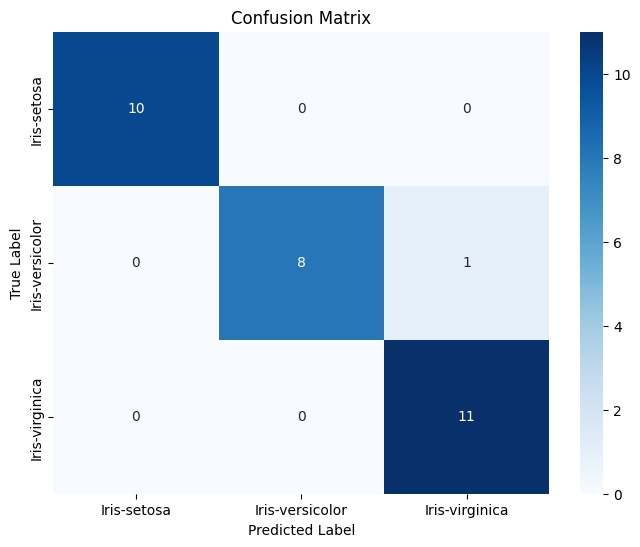

Feature Importances:
sepal_length: 0.2192
sepal_width: 0.1111
petal_length: 0.2067
petal_width: 0.1277
sepal_area: 0.1420
petal_area: 0.0800
sepal_petal_length_ratio: 0.0712
sepal_petal_width_ratio: 0.0170
aspect_ratio: 0.0252


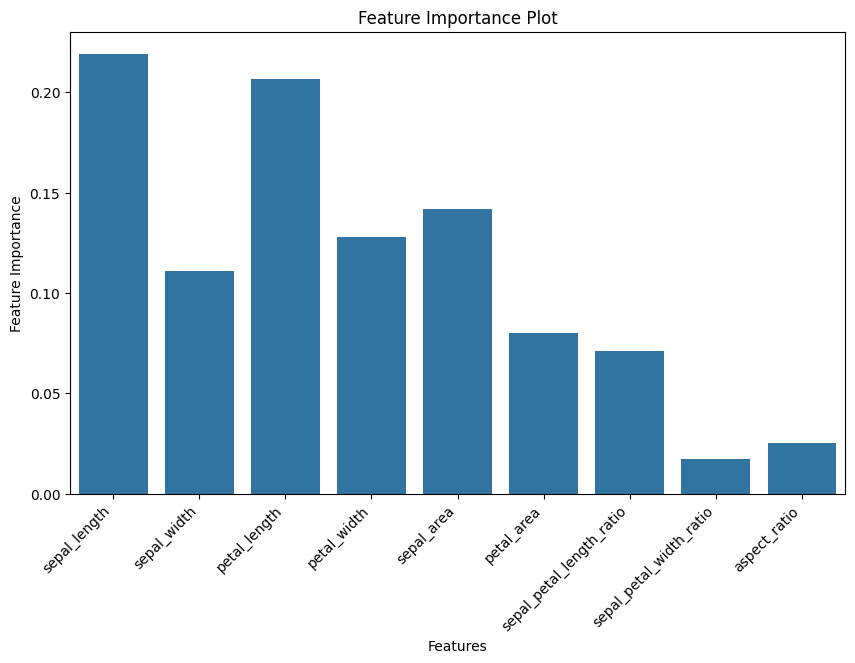

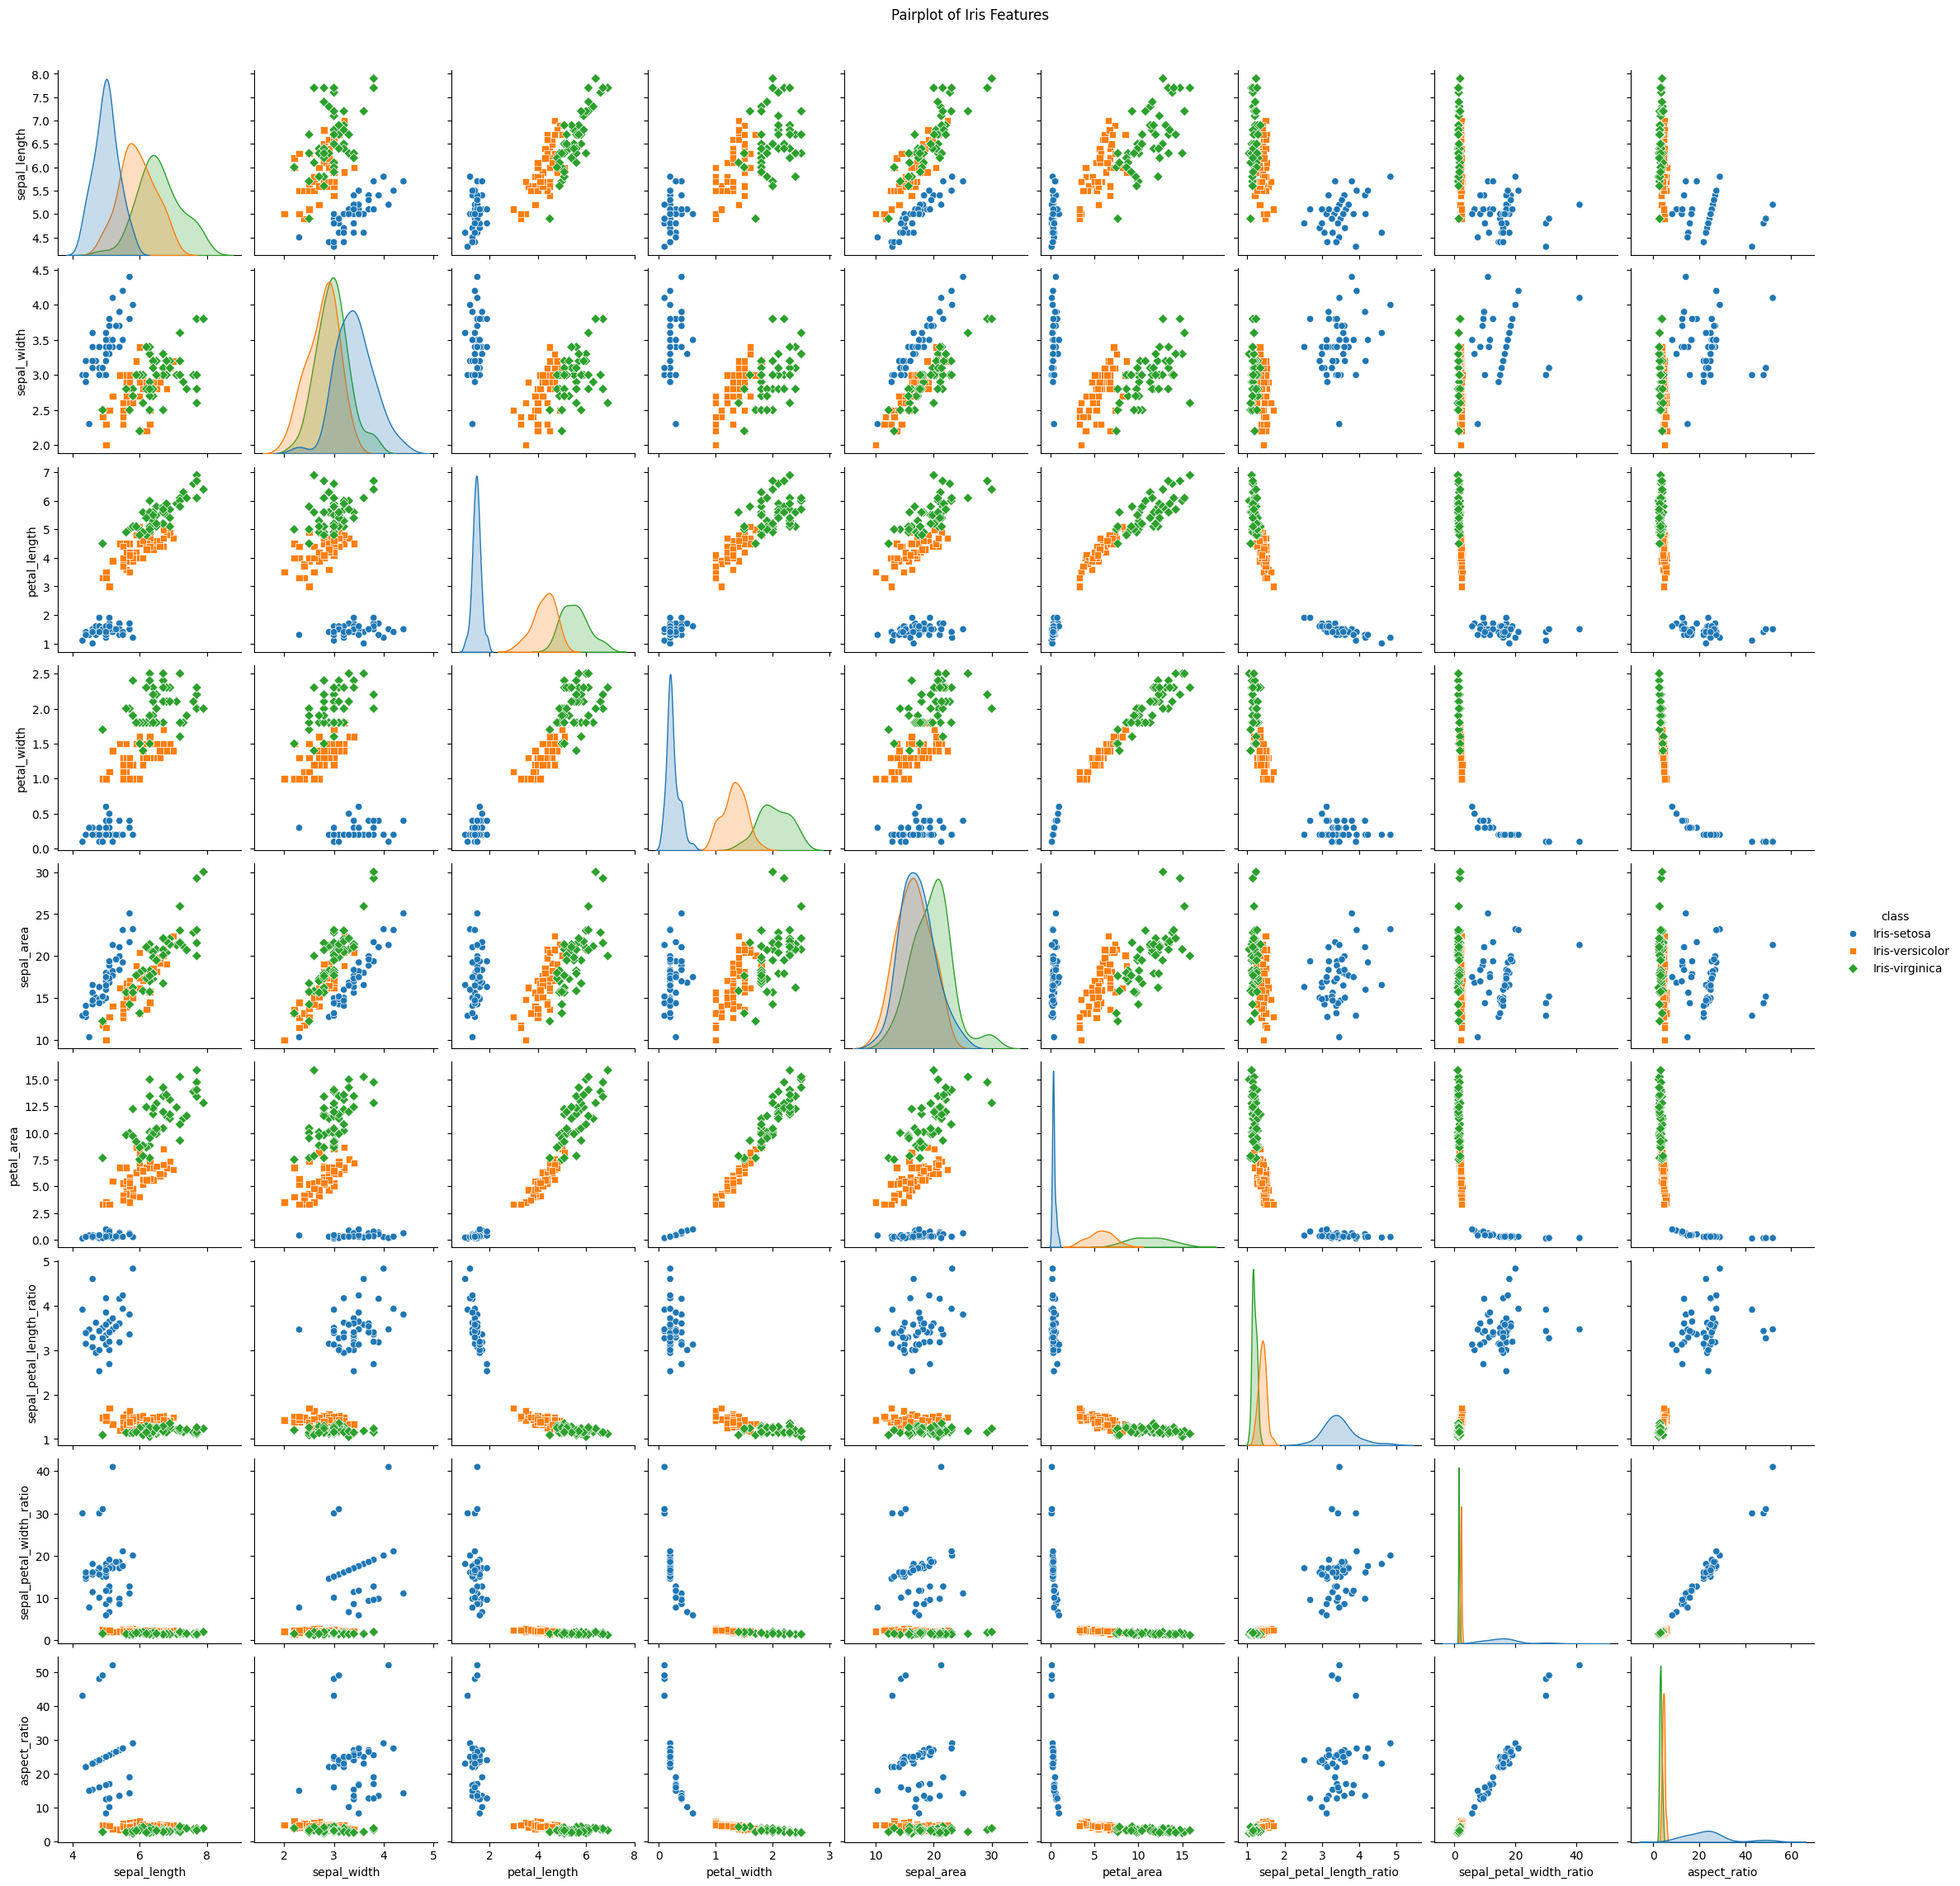

In [9]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Load the Iris Dataset ---

# Load the Iris dataset directly from the UCI Machine Learning Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris_df = pd.read_csv(url, names=names)

# --- Feature Engineering ---
# Create new features from existing ones to enhance data representation

# Calculate sepal and petal areas
iris_df['sepal_area'] = iris_df['sepal_length'] * iris_df['sepal_width']
iris_df['petal_area'] = iris_df['petal_length'] * iris_df['petal_width']

# Calculate ratios of sepal and petal dimensions
iris_df['sepal_petal_length_ratio'] = iris_df['sepal_length'] / iris_df['petal_length']
iris_df['sepal_petal_width_ratio'] = iris_df['sepal_width'] / iris_df['petal_width']

# Calculate aspect ratio (ratio of longest to shortest dimension)
def aspect_ratio(row):
  return max(row['sepal_length'], row['sepal_width'], row['petal_length'], row['petal_width']) / \
         min(row['sepal_length'], row['sepal_width'], row['petal_length'], row['petal_width'])

iris_df['aspect_ratio'] = iris_df.apply(aspect_ratio, axis=1)

# --- Data Preprocessing ---

# Separate features (X) and target variable (y)
X = iris_df.drop('class', axis=1)  # Features
y = iris_df['class']  # Target variable (class labels)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit scaler on training data and transform
X_test = scaler.transform(X_test)  # Transform test data using the fitted scaler

# --- Define Ensemble Models ---

# Define base estimators for the Stacking ensemble model
estimators = [
    ('lr', LogisticRegression()),  # Logistic Regression estimator
    ('svm', SVC()),  # Support Vector Machine estimator
    ('knn', KNeighborsClassifier())  # K-Nearest Neighbors estimator
]

# Initialize ensemble models with chosen base estimators and hyperparameters
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)  # Bagging with Decision Tree
boosting_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)  # Boosting with Decision Tree
stacking_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=42))  # Stacking with meta-learner

# --- Train and Evaluate Models ---

# Store models in a dictionary for easy access
models = {
    'Bagging': bagging_model,
    'Boosting': boosting_model,
    'Stacking': stacking_model
}

# Loop through each model, train, and evaluate
for name, model in models.items():
    # Hyperparameter tuning using GridSearchCV (example for Bagging)
    if name == 'Bagging':
        param_grid = {
            'estimator__max_depth': [3, 5, 7],  # Explore different max depths for the Decision Tree
            'n_estimators': [10, 20, 30]  # Explore different numbers of estimators
        }
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)  # 5-fold cross-validation
        grid_search.fit(X_train, y_train)  # Find the best hyperparameter combination
        model = grid_search.best_estimator_  # Use the best model

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Evaluate the model's performance using different metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the evaluation results
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("-" * 20)

    # --- Visualizations ---
    # Generate visualizations for the Stacking model

    if name == 'Stacking':
        feature_importances = model.final_estimator_.feature_importances_

        # Confusion Matrix: Visualize the model's classification performance
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris_df['class'].unique(), yticklabels=iris_df['class'].unique())
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

# Print feature importances from the Random Forest in Stacking
print("Feature Importances:")
for i, feature in enumerate(X.columns):
    print(f"{feature}: {feature_importances[i]:.4f}")

# Feature Importance Plot: Visualize the importance of each feature
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns, y=feature_importances)
plt.xticks(rotation=45, ha="right")
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

# Pairplot: Visualize relationships between pairs of features, colored by class
sns.pairplot(iris_df, hue='class', markers=["o", "s", "D"])
plt.suptitle("Pairplot of Iris Features", y=1.02)
plt.show()